## Simplicación del código 
*Tomado del repositorio https://github.com/alexbaryzhikov/triangulation*

In [1]:
"""
The divide-and-conquer algorithm for computing Delaunay triangulation of a set of points.
"""
import numpy as np

edges = [] # container for edges

# -----------------------------------------------------------------
# Interface method, that is supposed to be exported.


def delaunay(S):
    """Assumes S is a list of points of form (x, y).
    Returns a list of edges that form a Delaunay triangulation of S."""

    if len(S) < 2:
        print("Must be at least two points.")
        return
    
    global edges
    edges = []
    S = np.asarray(S, dtype=np.float64)
    
    
    # Sort points by x coordinate, y is a tiebreaker.
    S.view(dtype=[('f0', S.dtype), ('f1', S.dtype)]).sort(order=['f0', 'f1'], axis=0)
    
    # Remove duplicates.
    dupes = [i for i in range(1, len(S)) if S[i-1][0] == S[i][0] and S[i-1][1] == S[i][1]]
    if dupes:
        S = np.delete(S, dupes, 0)
        
    triangulate(S)    
    
    edges = [e for e in edges if e.data is None]  # clean the garbage 

    return edges


# -----------------------------------------------------------------
# Quad edge data structure.


class Edge:
    """A directed edge: org -> dest.
    When traversing edge ring: Next is CCW, Prev is CW."""

    def __init__(self, org, dest):
        self.org   = org
        self.dest  = dest
        self.onext = None
        self.oprev = None
        self.sym   = None    # symmetrical counterpart of this edge
        self.data  = None    # can store anyting (e.g. tag), for external use

    def __str__(self):
        s = str(self.org) + ', ' + str(self.dest)
        if self.data is None:
            return s
        else:
            return s + ' ' + str(self.data)


# -----------------------------------------------------------------
# Main triangulation routine


def triangulate(S):
    """Computes the Delaunay triangulation of a point set S and returns two edges, le and re,
    which are the counterclockwise convex hull edge out of the leftmost vertex and the clockwise
    convex hull edge out of the rightmost vertex, respectively."""
    
    # Caso base: complejidad O(1)
    if len(S) == 2:
        a = make_edge(S[0], S[1])
        return a, a.sym

    elif len(S) == 3: # Caso base: complejidad O(1)
        # Create edges a connecting p1 to p2 and b connecting p2 to p3.
        p1, p2, p3 = S[0], S[1], S[2]
        a = make_edge(p1, p2)
        b = make_edge(p2, p3)
        splice(a.sym, b)

        # Close the triangle.
        if right_of(p3, a):
            connect(b, a)
            return a, b.sym
        elif left_of(p3, a):
            c = connect(b, a)
            return c.sym, c
        else:  # the three points are collinear
            return a, b.sym

    else:
        # Recursively subdivide S.
        m = (len(S) + 1) // 2 
        L, R = S[:m], S[m:] # tamaño de los subproblemas, b=2
        ldo, ldi = triangulate(L) # llamadas recursivas, 2; a=2
        rdi, rdo = triangulate(R)

        # Compute the upper common tangent of L and R.
        while True: # complejidad O(n), pues se recorren por lo menos una vez cada punto
            if right_of(rdi.org, ldi):
                ldi = ldi.sym.onext
            elif left_of(ldi.org, rdi):
                rdi = rdi.sym.oprev
            else:
                break

        # Create a first cross edge base from rdi.org to ldi.org.
        base = connect(ldi.sym, rdi) # complejidad O(1)

        # Adjust ldo and rdo
        if ldi.org[0] == ldo.org[0] and ldi.org[1] == ldo.org[1]:
            ldo = base
        if rdi.org[0] == rdo.org[0] and rdi.org[1] == rdo.org[1]:
            rdo = base.sym

        # Merge.
        while True: # complejidad O(n)
            # Locate the first R and L points to be encountered by the diving bubble.
            rcand, lcand = base.sym.onext, base.oprev
            # If both lcand and rcand are invalid, then base is the lower common tangent.
            v_rcand, v_lcand = right_of(rcand.dest, base), right_of(lcand.dest, base)
            if not (v_rcand or v_lcand):
                break
            # Delete R edges out of base.dest that fail the circle test.
            if v_rcand:
                while right_of(rcand.onext.dest, base) and \
                      in_circle(base.dest, base.org, rcand.dest, rcand.onext.dest) == 1:
                    t = rcand.onext
                    delete_edge(rcand)
                    rcand = t
            # Symmetrically, delete L edges.
            if v_lcand:
                while right_of(lcand.oprev.dest, base) and \
                      in_circle(base.dest, base.org, lcand.dest, lcand.oprev.dest) == 1:
                    t = lcand.oprev
                    delete_edge(lcand)
                    lcand = t
            # The next cross edge is to be connected to either lcand.dest or rcand.dest.
            # If both are valid, then choose the appropriate one using the in_circle test.
            if not v_rcand or \
               (v_lcand and in_circle(rcand.dest, rcand.org, lcand.org, lcand.dest) == 1):
                # Add cross edge base from rcand.dest to base.dest.
                base = connect(lcand, base.sym)
            else:
                # Add cross edge base from base.org to lcand.dest
                base = connect(base.sym, rcand.sym)

        return ldo, rdo


# -----------------------------------------------------------------
# Predicates


def in_circle(a, b, c, d):
    """Does d lie inside of circumcircle abc?"""
    a1, a2 = a[0]-d[0], a[1]-d[1]
    b1, b2 = b[0]-d[0], b[1]-d[1]
    c1, c2 = c[0]-d[0], c[1]-d[1]
    a3, b3, c3 = a1**2 + a2**2, b1**2 + b2**2, c1**2 + c2**2
    det = a1*b2*c3 + a2*b3*c1 + a3*b1*c2 - (a3*b2*c1 + a1*b3*c2 + a2*b1*c3)
    return det < 0


def right_of(p, e):
    """Does point p lie to the right of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det > 0


def left_of(p, e):
    """Does point p lie to the left of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det < 0


# -----------------------------------------------------------------
# Topological operators


def make_edge(org, dest):
    """Creates a new edge. Assumes org and dest are points."""

    global edges
    e  = Edge(org, dest)
    es = Edge(dest, org)
    e.sym, es.sym = es, e  # make edges mutually symmetrical
    e.onext, e.oprev = e, e
    es.onext, es.oprev = es, es
    edges.append(e)
    return e


def splice(a, b):
    """Combines distinct edge rings / breaks the same ring in two pieces. Merging / tearing goes
    between a and a.onext through a.org to between b and b.onext."""

    if a == b:
        print("Splicing edge with itself, ignored: {}.".format(a))
        return

    a.oprev, b.onext.oprev = b, a
    a.onext, b.onext = b.onext, a.onext


def connect(a, b):
    """Adds a new edge e connecting the destination of a to the origin of b, in such a way that
    a Left = e Left = b Left after the connection is complete."""
    e = make_edge(a.dest, b.org)
    splice(e, a.sym.oprev)
    splice(e.sym, b)
    return e


def delete_edge(e):
    """Disconnects the edge e from the rest of the structure (this may cause the rest of the
    structure to fall apart in two separate components)."""
    splice(e, e.oprev)
    splice(e.sym, e.sym.oprev)
    e.data, e.sym.data = True, True

In [2]:
def gen_random(w, h, n):
    """Returns an array of randomly generated points.
       w, h     width, height
       n        number of points"""
    np.random.seed(0)
    points_x = np.random.randint(0, w, n, dtype=np.int64)
    points_y = np.random.randint(0, h, n, dtype=np.int64)
    return np.asarray(list(zip(points_x, points_y)), dtype=np.float64)

In [3]:
#points = [[1,1],[5,1],[3,3]]
points = [[1,1],[3,0],[5,1],[8,3],[7,4],[5,5],[3,7],[1.5,6],[1,5],[2,4.5],[3,4],[3,3],[2,3],[0,3]]
edges = delaunay(points)
print("Number of edges (random): " + str(len(edges)))

Number of edges (random): 26


TypeError: list indices must be integers or slices, not tuple

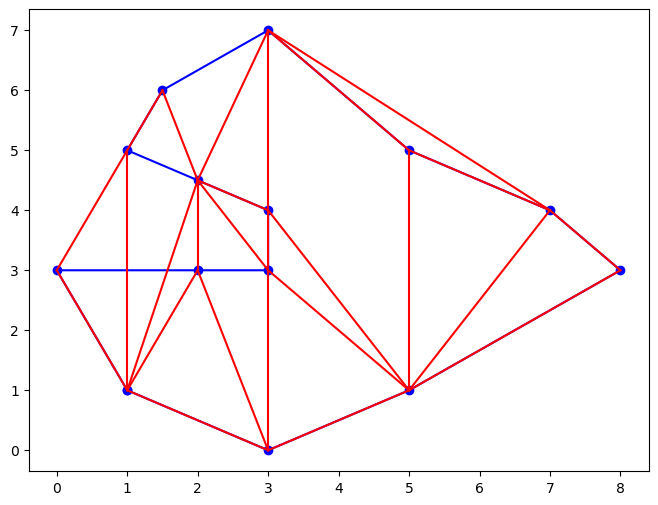

In [4]:
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Visualización
plt.figure(figsize=(8, 6))
polygon_points = points
# Crear un camino para el polígono
polygon_path = Path(polygon_points)

# Polígono
plt.plot(*zip(*np.vstack([polygon_points, polygon_points[0]])), 'b-o', label='Polígono')

for tri in edges:
    plt.plot([tri.org[0],tri.dest[0]], [tri.org[1],tri.dest[1]], 'r-')
    
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=5)
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Triangulación de un Polígono Convexo')
plt.axis('equal')
plt.show()